In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy import units as u
from astropy.coordinates import EarthLocation
from astropy.time import Time

from astroplan.plots import plot_airmass
from matplotlib import pyplot as plt
%matplotlib inline

from astroplan import Observer

from pocs.scheduler.dispatch import Scheduler
from pocs.scheduler.constraint import Duration
from pocs.utils.config import load_config

config = load_config()

/home/wtgee/miniconda/lib/python3.5/site-packages/PIL/Image.py:84: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/home/wtgee/miniconda/lib/python3.5/site-packages/PIL/Image.py:84: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


In [3]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])

# Get an observer at the location
observer = Observer(location=location)

# Get the night hours (you can use observer.tonight())
start_of_night = Time('2016-08-15 06:57:45')
end_of_night = Time('2016-08-15T14:46:08')

In [4]:
simple_fields_file = config['directories']['targets'] + '/default_targets.yaml'

# Simple constraint to maximize duration above a certain altitude
constraints = [Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(simple_fields_file, observer, constraints=constraints)

In [5]:
for obs in scheduler.observations.values():
    print(obs)

HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 17156: 120.0 s exposures in blocks of 10, minimum 60, priority 120
M 42: 120.0 s exposures in blocks of 10, minimum 60, priority 105
Kelt-3: 120.0 s exposures in blocks of 10, minimum 60, priority 125
Wasp 52: 120.0 s exposures in blocks of 10, minimum 60, priority 110
HAT-P-16: 120.0 s exposures in blocks of 10, minimum 60, priority 115
Kelt-7: 120.0 s exposures in blocks of 10, minimum 60, priority 125
Wasp 35: 120.0 s exposures in blocks of 10, minimum 60, priority 125
Groombridge 1618: 120.0 s exposures in blocks of 10, minimum 60, priority 125
HR 8799: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 76: 120.0 s exposures in blocks of 10, minimum 60, priority 115
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 130
Tres 3: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 189733: 120.0 s expo

In [6]:
# Get the best observations for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=start_of_night)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: Tres 3       Merit: 101.52673716564992
Field: HD 209458    Merit: 101.49455088729071


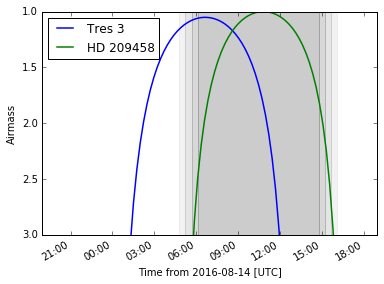

In [7]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, start_of_night, 
             brightness_shading=True)
        
plt.legend(loc=2)
plt.show()

In [8]:
# Set a later time to start
t2 = end_of_night - 3 * u.hour

# Get the best observation for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: Wasp 33      Merit: 132.0
Field: Wasp 76      Merit: 116.92144092571915
Field: HD 209458    Merit: 102.0


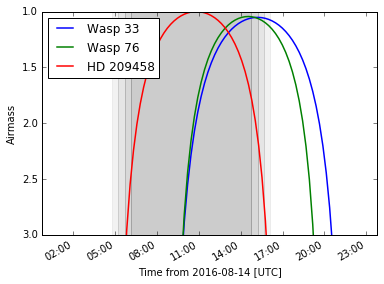

In [9]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
        
plt.legend(loc=2)
plt.show()

## Entire Night Simulation

Now let's simulate going through the whole evening

In [10]:
# Start at the beginning of the night
next_time = start_of_night
print("Start of night at {}".format(start_of_night))

# Reset scheduler
# Create a scheduler
scheduler = Scheduler(simple_fields_file, observer, constraints=constraints)

while (next_time < end_of_night):    
    # Only get new target if we have met min_nexp for observation
    if (scheduler.current_observation is None) or \
        (scheduler.current_observation.current_exp >= scheduler.current_observation.min_nexp):
        
        print("Getting new observation at {}".format(next_time))
        new_obs = scheduler.get_observation(time=next_time)
#         print(new_obs)
        
    if scheduler.current_observation is not None:

        if (scheduler.current_observation.current_exp < scheduler.current_observation.min_nexp):
            obs_duration = scheduler.current_observation.minimum_duration

            # Fake the exposure count
            scheduler.current_observation.current_exp = scheduler.current_observation.min_nexp
        else:
            obs_duration = scheduler.current_observation.set_duration
            # Fake the exposure count
            scheduler.current_observation.current_exp += scheduler.current_observation.exp_set_size

        print("\tWill observe {} with merit of {:0.5f} for {}".format(
                    scheduler.current_observation.name, 
                    scheduler.current_observation.merit, 
                    obs_duration))
        print("\t{} of {}".format(scheduler.current_observation.current_exp, 
                                  scheduler.current_observation.min_nexp))
                
    next_time = next_time + obs_duration
    
print("End of night at {}".format(end_of_night))

Start of night at 2016-08-15 06:57:45.000
Getting new observation at 2016-08-15 06:57:45.000
	Will observe Tres 3 with merit of 101.52674 for 7200.0 s
	60 of 60
Getting new observation at 2016-08-15 08:57:45.000
	Will observe HAT-P-16 with merit of 116.76428 for 7200.0 s
	60 of 60
Getting new observation at 2016-08-15 10:57:45.000
	Will observe Wasp 33 with merit of 132.00000 for 7200.0 s
	60 of 60
Getting new observation at 2016-08-15 12:57:45.000
	Will observe Wasp 33 with merit of 132.00000 for 1200.0 s
	70 of 60
Getting new observation at 2016-08-15 13:17:45.000
	Will observe Wasp 33 with merit of 132.00000 for 1200.0 s
	80 of 60
Getting new observation at 2016-08-15 13:37:45.000
	Will observe Wasp 33 with merit of 132.00000 for 1200.0 s
	90 of 60
Getting new observation at 2016-08-15 13:57:45.000
	Will observe Wasp 33 with merit of 132.00000 for 1200.0 s
	100 of 60
Getting new observation at 2016-08-15 14:17:45.000
	Will observe Wasp 33 with merit of 132.00000 for 1200.0 s
	110 of

2016-08-15 18:50:21 ganymede panoptes[29436] WARNING No valid observations found


End of night at 2016-08-15T14:46:08.000
